# Bibliotecas e Ambiente

In [2]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier,
)
from capymoa.evaluation import (
    ClassificationEvaluator,
    prequential_evaluation, 
    ClassificationWindowedEvaluator,
    prequential_evaluation_multiple_learners,
    prequential_ssl_evaluation
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream
import random
from collections import deque
from capymoa.drift.detectors import DDM, ADWIN, ABCD

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Streams

## Real

### CICDDoS2019

In [4]:
from py.functions import criar_stream

FILE_RAW = r'datasets\CICDDoS2019\data\CICDDoS2019_01_12.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'

TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas 
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
CICDDoS2019, le_global = criar_stream(
    file_path=FILE_RAW,
    target_label_col=TARGET_COL,
    timestamp_col=TIME_COL,
    cols_para_remover=COLS_NAO_FEATURES,
    features_selecionadas=TOP_20_FEATURES
)

--- Iniciando Pipeline: datasets\CICDDoS2019\data\CICDDoS2019_01_12.csv ---
  [Passo 2/6] Colunas renomeadas.
  [Passo 3/6] Ordenando DataFrame por 'Timestamp'...
  [Passo 4/6] Convertendo valores Infinitos para NaN...
  [Passo 5/6] Removendo colunas, tratando nulos e codificando rótulos...
    - LabelEncoder criado e ajustado. 12 classes encontradas.
    - 7 colunas removidas do conjunto de features.
    - Imputando 3142 valores nulos/infinitos com a MEDIANA...
    - Aplicando seleção de features. Mantendo 20 colunas.
  [Passo 6/6] Criando objeto NumpyStream...
    - Dados finais preparados: X_shape=(93070, 20), y_shape=(93070,).
Stream criado e pronto para uso.


## Sintética

In [3]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=2000, width=500),
            RandomTreeGenerator(tree_random_seed=2),
            AbruptDrift(position=3000),
            RandomTreeGenerator(tree_random_seed=2),
        ]
    ),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=2),
            AbruptDrift(position=2000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=4),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=4,
        magnitude_of_change=0.0,
    ),

    "Robust_Drift": DriftStream(
        stream=[
            # 0-2000
            RandomRBFGenerator(
                model_random_seed=1, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=50
            ),
            # 2000-4000 (Testa DDM/ADWIN)
            AbruptDrift(position=2000),
            RandomTreeGenerator(
                tree_random_seed=1, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 4000-6000 (Testa ABCD)
            AbruptDrift(position=4000),
            RandomRBFGenerator(
                model_random_seed=2, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=20
            ),
            # 6000-8000 (Testa DDM/ADWIN)
            AbruptDrift(position=6000),
            RandomTreeGenerator(
                tree_random_seed=2, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 8000-10000 (Testa ABCD)
            GradualDrift(position=8000, width=1000),
            RandomRBFGeneratorDrift(
                model_random_seed=4, 
                instance_random_seed=1, 
                number_of_attributes=10, 
                number_of_drifting_centroids=20, 
                magnitude_of_change=0.5
            )
        ]
    )

}

# Algoritmos de Stream Mining

## Leveraging Bagging (LB) 

https://capymoa.org/api/modules/capymoa.classifier.LeveragingBagging.html

* **Schema** – O esquema do fluxo. Se não for fornecido, será inferido a partir dos dados.
* **CLI** – Opções da Interface de Linha de Comando (CLI) para configurar o algoritmo ARF. Se não forem fornecidas, as opções padrão serão utilizadas.
* **random_seed** – Semente para o gerador de números aleatórios.
* **base_learner** – O modelo base a ser usado. Se não for fornecido, uma árvore de Hoeffding padrão será utilizada.
* **ensemble_size** – O número de árvores no conjunto.
* **minibatch_size** – O número de instâncias que um algoritmo de aprendizado deve acumular antes do treinamento.
* **number_of_jobs** – O número de tarefas paralelas a serem executadas durante a execução do algoritmo. Por padrão, o algoritmo executa as tarefas sequencialmente (ou seja, com `number_of_jobs=1` ). Aumentar o valor de `number_of_jobs` pode levar a uma execução mais rápida em sistemas com múltiplos núcleos. No entanto, definir um valor alto pode consumir mais recursos do sistema e memória. Esta implementação prioriza o desempenho, portanto, o desempenho preditivo é modificado. Recomenda-se experimentar com diferentes valores para encontrar a configuração ideal com base nos recursos de hardware disponíveis e na natureza da carga de trabalho.

### Hiperparâmetros

In [34]:
MAX_INSTANCES = 10000
WINDOW_SIZE = 500
DELAY_LENGTH = 500
LABEL_PROBABILITY = 0.50

# Para alterar entre as streams sintética e real
stream = streams["Robust_Drift"]
print(stream.get_schema())

LB = LeveragingBagging(
    schema=stream.schema, 
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=None # Padrão (None)
)

classificationEvaluatorLB = ClassificationEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)
windowedEvaluatorLB = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)

drift_detector_DDM = DDM()
drift_detector_ADWIN = ADWIN()

@relation 'generators.RandomRBFGenerator '

@attribute att1 numeric
@attribute att2 numeric
@attribute att3 numeric
@attribute att4 numeric
@attribute att5 numeric
@attribute att6 numeric
@attribute att7 numeric
@attribute att8 numeric
@attribute att9 numeric
@attribute att10 numeric
@attribute class {class1,class2}

@data


### LB - Supervisionado

Resultados Cumulativos
Accuracy: 77.22
F1_Score: 76.66931372541525


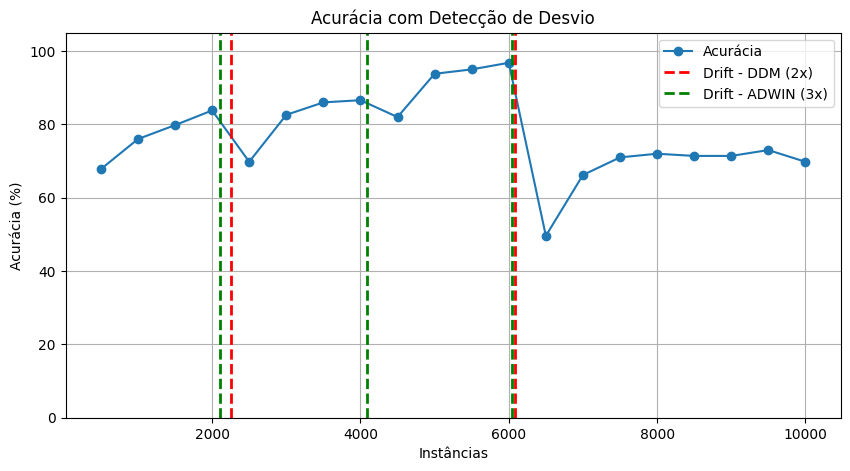

In [35]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    prediction = LB.predict(instance)
    
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    classificationEvaluatorLB.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    LB.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorLB.accuracy()}")
print(f"F1_Score: {classificationEvaluatorLB.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(10, 5))
plt.plot(instance_count_history, window_accuracy_history, 'o-', label='Acurácia')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=2, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='--', 
           linewidth=2, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia com Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True)
plt.legend()
plt.show()

Supervisionado
Accuracy: 79.47999999999999
f1_score: 78.86646723011643


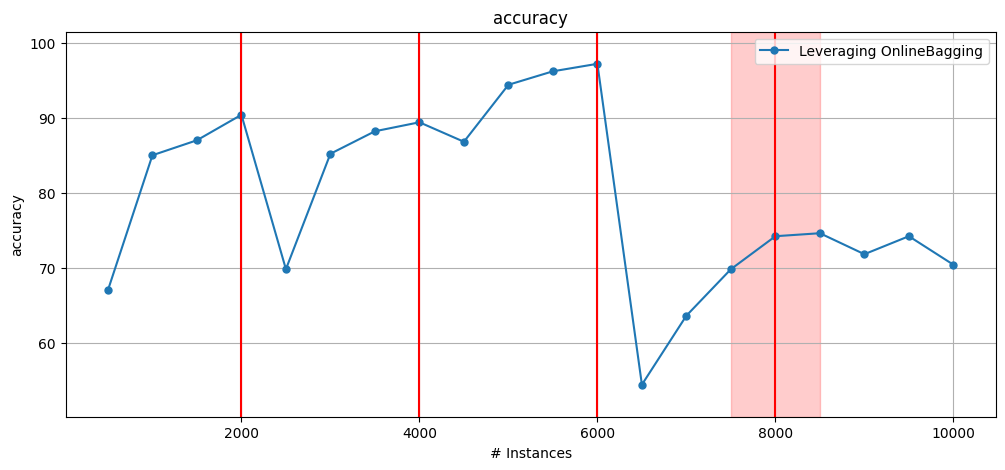

In [36]:
# Hyperparâmetros padrão
result_prequential = prequential_evaluation(
    stream=stream,
    learner=LB,
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("Supervisionado")
print("Accuracy:", result_prequential['cumulative'].accuracy())
print("f1_score:", result_prequential['cumulative'].f1_score())
# display(result_prequential['windowed'].metrics_per_window())
plot_windowed_results(result_prequential, metric="accuracy")

### LB - Semi-supervised Learning (SSL)

Resultados Cumulativos
Accuracy: 78.245
F1_Score: 77.61074324264098


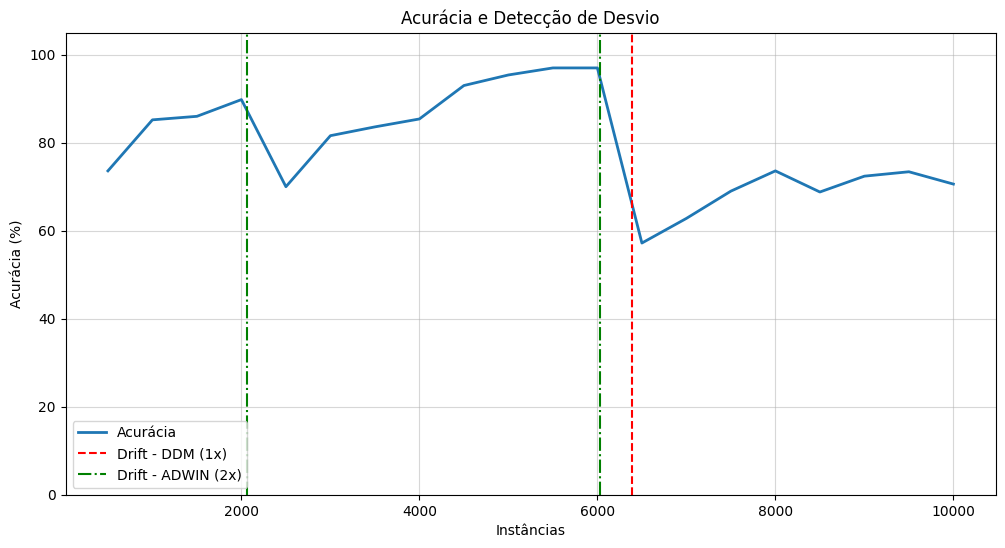

In [37]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Ocorre imediatamente
    prediction = LB.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente
    classificationEvaluatorLB.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Se a instância for selecionada aleatoriamente (LABEL_PROBABILITY),
    # o modelo treina. Caso contrário, o treino é pulado.
    if random.random() <= LABEL_PROBABILITY:
        LB.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1


print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorLB.accuracy()}")
print(f"F1_Score: {classificationEvaluatorLB.f1_score()}")

plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label=f'Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title(f'Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

SSL
Accuracy: 80.33
f1_score: 79.78391548399136


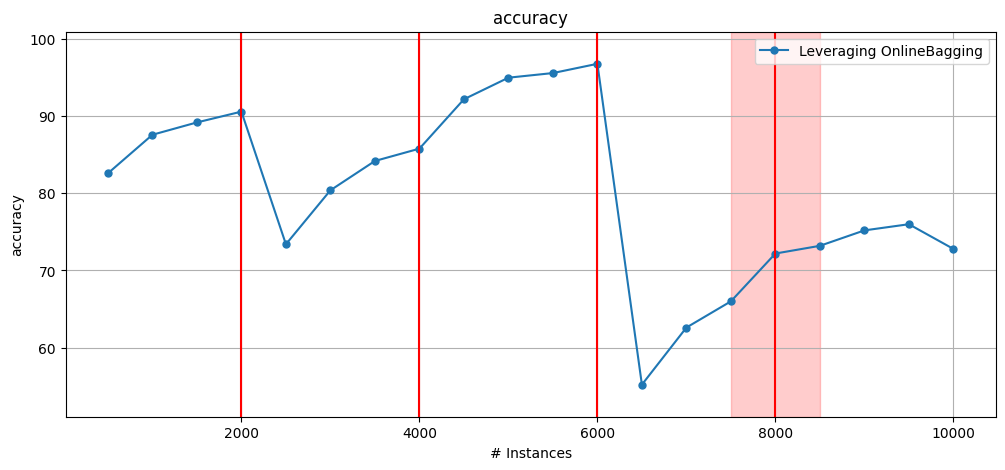

In [38]:
# Hyperparâmetros padrão para SSL
result_ssl_prequential = prequential_ssl_evaluation(
    stream=stream, 
    learner=LB, 
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    initial_window_size=0,
    delay_length=0,
    label_probability=LABEL_PROBABILITY,
    random_seed=1,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("SSL")
print("Accuracy:", result_ssl_prequential['cumulative'].accuracy())
print("f1_score:", result_ssl_prequential['cumulative'].f1_score())
# display(result_ssl_prequential['windowed'].metrics_per_window())
plot_windowed_results(result_ssl_prequential, metric="accuracy")


### LB - SSL com Delay

Resultados Cumulativos
Accuracy: 78.09
F1_Score: 77.41943508580383


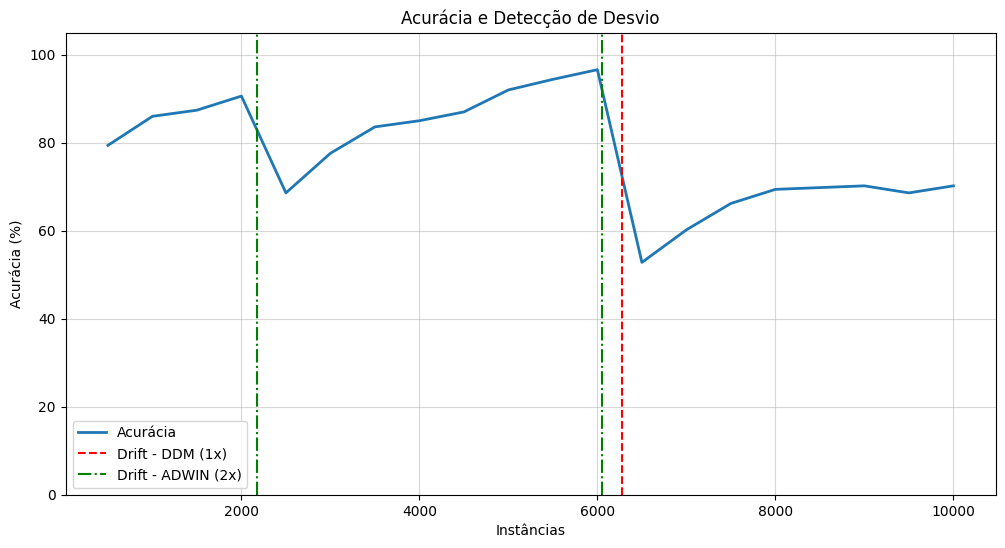

In [39]:
# Fila para armazenar instâncias para treino atrasado
prediction_queue = deque(maxlen=DELAY_LENGTH) 

window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE)  
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # (Predict) - Ocorre imediatamente
    prediction = LB.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente com o rótulo conhecido
    classificationEvaluatorLB.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN 
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Determina se o rótulo está disponível (SSL)
    if random.random() <= LABEL_PROBABILITY:
        # Rótulo disponível: Armazenamos a instância completa para treino futuro
        prediction_queue.append(instance) 
    else:
        # Rótulo NÃO disponível: Armazenamos None para manter o delay
        prediction_queue.append(None)
        
    # TREINO ATRASADO (Delayed Train)
    if len(prediction_queue) == DELAY_LENGTH:
        delayed_item = prediction_queue.popleft()
        
        # Só treina se o rótulo estiver disponível no item que saiu da fila
        if delayed_item is not None:
            LB.train(delayed_item)
            # print(f"Treinado na instância {count - DELAY_LENGTH + 1} com rótulo disponível.")
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorLB.accuracy()}")
print(f"F1_Score: {classificationEvaluatorLB.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label='Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

### Comparação dos Resultados

Foi comentado o result_ssl_prequential_delay, pois ainda não foi implementado no capyMOA (Delay e o Tamanho da Janela Inicial)

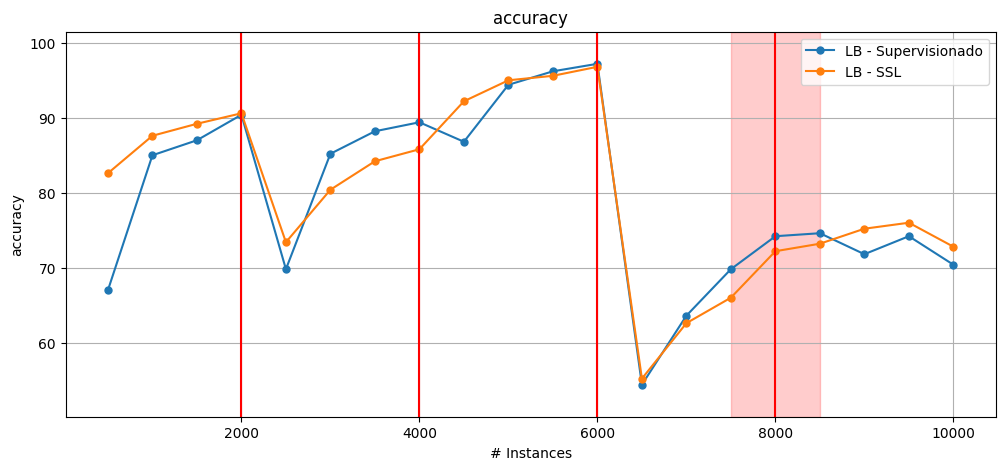

In [40]:
# Rótulos para os gráficos
result_prequential.learner = "LB - Supervisionado"
result_ssl_prequential.learner = "LB - SSL"
# result_ssl_prequential_delay.learner = "LB - SSL com Delay"

# Plot dos resultados
plot_windowed_results(
    result_prequential, 
    result_ssl_prequential, 
    # result_ssl_prequential_delay, 
    metric="accuracy"
)

## Hoeffding Adaptive Tree (HAT)

https://capymoa.org/api/modules/capymoa.classifier.HoeffdingAdaptiveTree.html

* **schema** - o esquema do fluxo.
* **random_seed** – a semente aleatória passada para o algoritmo de aprendizado do Moa.
* **grace_period** – o número de instâncias que uma folha deve observar entre as tentativas de divisão.
* **split_criterion** – o critério de divisão a ser usado. O padrão é InfoGainSplitCriterion .
* **confidence**  – o nível de confiança para calcular o Limite de Hoeffding (1 - delta). O valor padrão é 1e-3 . Valores mais próximos de zero implicam em maiores atrasos na decisão dividida.
* **tie_threshold** – o limite abaixo do qual uma divisão será forçada para desempatar.
* **leaf_prediction** – o mecanismo de predição usado nas folhas.
    * 0 - Classe majoritária
    * 1 - Naive Bayes
    * 2 - Naive Bayes adaptativo

* **nb_threshold** – o número de instâncias que uma folha deve observar antes de permitir o Naive Bayes.
* **numeric_attribute_observer** – o Splitter ou Observador de Atributos (AO) usado para monitorar as estatísticas de classe de recursos numéricos e realizar divisões.
* **binary_split** – Se verdadeiro, permite apenas divisões binárias.
* **max_byte_size** – o tamanho máximo da árvore, em bytes.
* **memory_estimate_period** – Intervalo (número de instâncias processadas) entre as verificações de consumo de memória.
* **stop_mem_management** – ​​Se verdadeiro, interrompe o crescimento assim que o limite de memória for atingido.
* **remove_poor_attrs** – Se verdadeiro, desativa atributos de baixa qualidade para reduzir o uso de memória.
* **disable_prepruning** – Se verdadeiro, desativa a pré-poda de árvores baseada em mérito.

### Hiperparâmetros

In [8]:
MAX_INSTANCES = 80000
WINDOW_SIZE = 1000
DELAY_LENGTH = 300
LABEL_PROBABILITY = 0.5

# Para alterar entre as streams sintética e real
# stream = streams["SEA_drift"]
stream = CICDDoS2019
print(stream.get_schema())

HAT = HoeffdingAdaptiveTree(
    schema=stream.schema,
    random_seed=0, # Padrão (0)
    grace_period=200, # Padrão (200)
    split_criterion='InfoGainSplitCriterion', # Padrão ('InfoGainSplitCriterion')
    confidence=0.01, # Padrão (0.01)
    tie_threshold=0.05, # Padrão (0.05)
    leaf_prediction='NaiveBayesAdaptive',
    nb_threshold=0, # Padrão (0)
    numeric_attribute_observer='GaussianNumericAttributeClassObserver', # Padrão ('GaussianNumericAttributeClassObserver')
    binary_split=False, # Padrão (False)
    max_byte_size=33554432, # Padrão (32MB)
    memory_estimate_period=1000000, # Padrão (1.000.000)
    stop_mem_management=True, # Padrão (True)
    remove_poor_attrs=False, # Padrão (False)
    disable_prepruning=True # Padrão (True)
)

classificationEvaluatorHAT = ClassificationEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)
windowedEvaluatorHAT = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)

drift_detector_DDM = DDM()
drift_detector_ADWIN = ADWIN()

@relation 'datasets\\CICDDoS2019\\CICDDoS2019_01_12.csv'

@attribute attrib_0 numeric
@attribute attrib_1 numeric
@attribute attrib_2 numeric
@attribute attrib_3 numeric
@attribute attrib_4 numeric
@attribute attrib_5 numeric
@attribute attrib_6 numeric
@attribute attrib_7 numeric
@attribute attrib_8 numeric
@attribute attrib_9 numeric
@attribute attrib_10 numeric
@attribute attrib_11 numeric
@attribute attrib_12 numeric
@attribute attrib_13 numeric
@attribute attrib_14 numeric
@attribute attrib_15 numeric
@attribute attrib_16 numeric
@attribute attrib_17 numeric
@attribute attrib_18 numeric
@attribute attrib_19 numeric
@attribute Label {0,1,2,3,4,5,6,7,8,9,10,11}

@data


### HAT - Supervisionado

Resultados Cumulativos
Accuracy: 99.13374999999999
F1_Score: 95.94002100043579


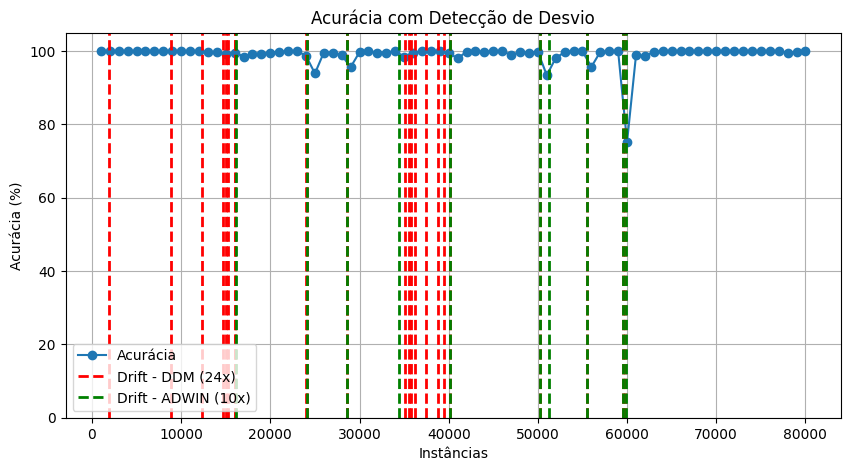

In [9]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    prediction = HAT.predict(instance)
    
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    classificationEvaluatorHAT.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    HAT.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorHAT.accuracy()}")
print(f"F1_Score: {classificationEvaluatorHAT.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(10, 5))
plt.plot(instance_count_history, window_accuracy_history, 'o-', label='Acurácia')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=2, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='--', 
           linewidth=2, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia com Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True)
plt.legend()
plt.show()

Supervisionado
Accuracy: 99.17625
f1_score: 96.03003851475557


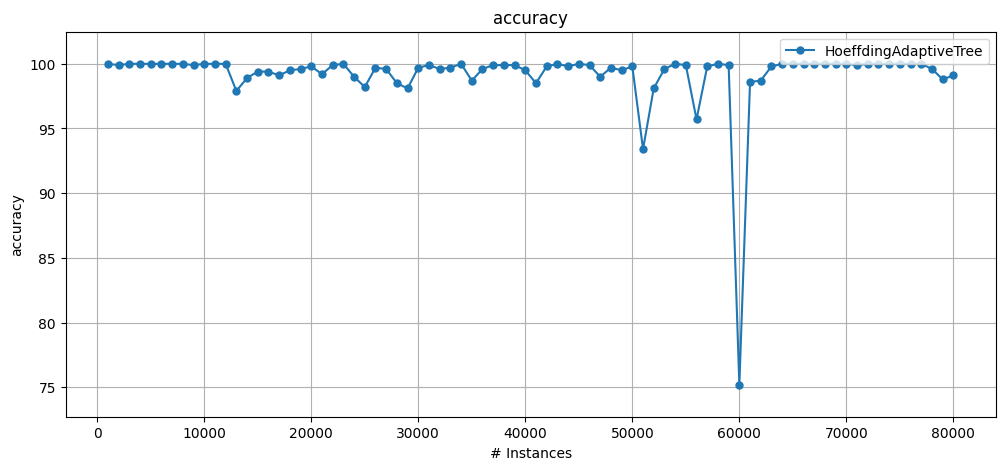

In [10]:
# Hyperparâmetros padrão
result_prequential_HAT = prequential_evaluation(
    stream=stream,
    learner=HAT,
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("Supervisionado")
print("Accuracy:", result_prequential_HAT['cumulative'].accuracy())
print("f1_score:", result_prequential_HAT['cumulative'].f1_score())
# display(result_prequential_HAT['windowed'].metrics_per_window())
plot_windowed_results(result_prequential_HAT, metric="accuracy")

### HAT - Semi-supervised Learning (SSL)

Resultados Cumulativos
Accuracy: 96.844375
F1_Score: 92.09768542490883


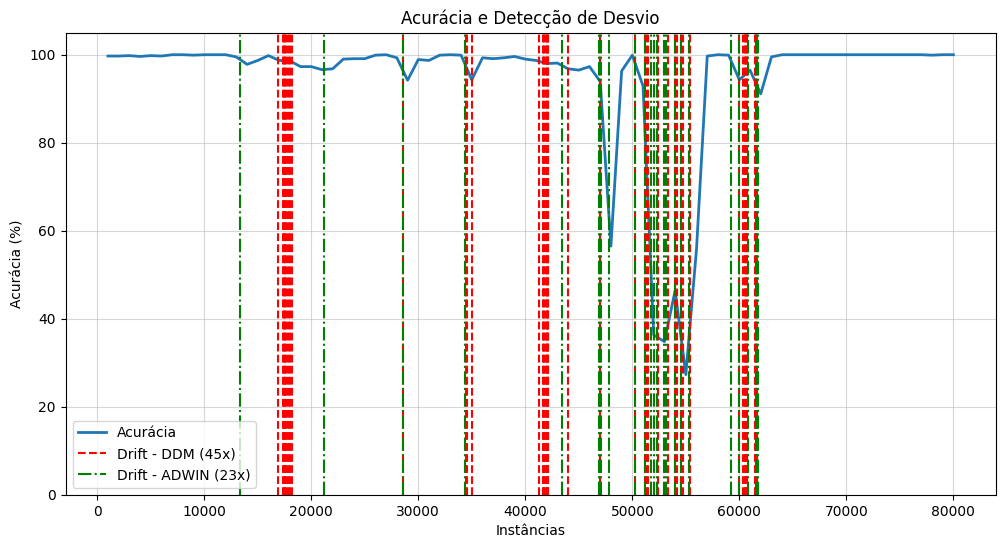

In [11]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Ocorre imediatamente
    prediction = HAT.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente
    classificationEvaluatorHAT.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Se a instância for selecionada aleatoriamente (LABEL_PROBABILITY),
    # o modelo treina. Caso contrário, o treino é pulado.
    if random.random() <= LABEL_PROBABILITY:
        HAT.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1


print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorHAT.accuracy()}")
print(f"F1_Score: {classificationEvaluatorHAT.f1_score()}")

plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label=f'Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title(f'Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

SSL
Accuracy: 98.60624999999999
f1_score: 95.61926323063223


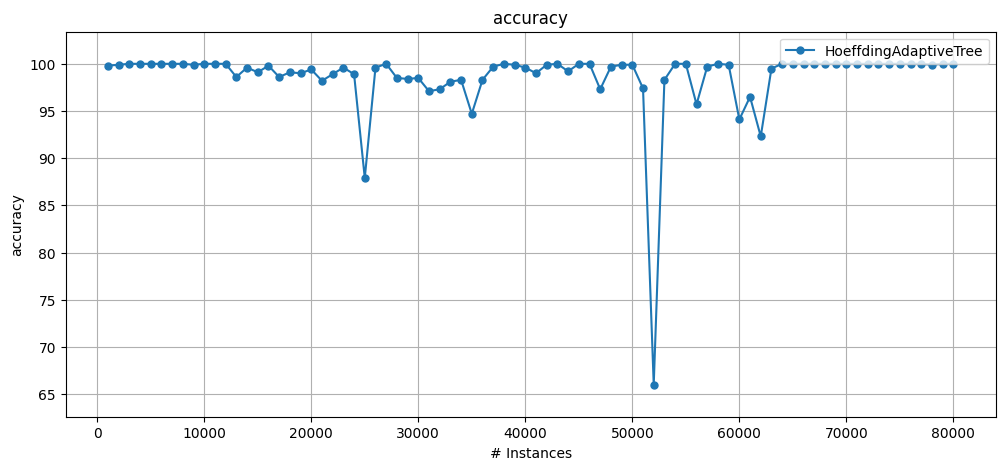

In [14]:
# Hyperparâmetros padrão para SSL
result_ssl_prequential_HAT = prequential_ssl_evaluation(
    stream=stream, 
    learner=HAT, 
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    initial_window_size=0,
    delay_length=0,
    label_probability=LABEL_PROBABILITY,
    random_seed=1,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("SSL")
print("Accuracy:", result_ssl_prequential_HAT['cumulative'].accuracy())
print("f1_score:", result_ssl_prequential_HAT['cumulative'].f1_score())
# display(result_ssl_prequential_HAT['windowed'].metrics_per_window())
plot_windowed_results(result_ssl_prequential_HAT, metric="accuracy")


### HAT - SSL com Delay

Resultados Cumulativos
Accuracy: 95.15875
F1_Score: 87.29843018172483


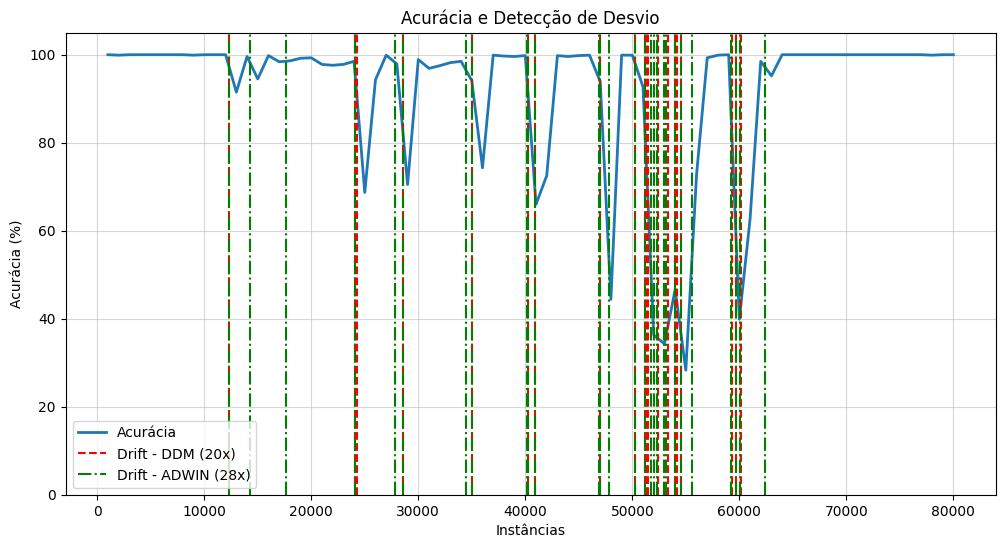

In [15]:
# Fila para armazenar instâncias para treino atrasado
prediction_queue = deque(maxlen=DELAY_LENGTH) 

window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE)  
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # (Predict) - Ocorre imediatamente
    prediction = HAT.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente com o rótulo conhecido
    classificationEvaluatorHAT.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN 
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Determina se o rótulo está disponível (SSL)
    if random.random() <= LABEL_PROBABILITY:
        # Rótulo disponível: Armazenamos a instância completa para treino futuro
        prediction_queue.append(instance) 
    else:
        # Rótulo NÃO disponível: Armazenamos None para manter o delay
        prediction_queue.append(None)
        
    # TREINO ATRASADO (Delayed Train)
    if len(prediction_queue) == DELAY_LENGTH:
        delayed_item = prediction_queue.popleft()
        
        # Só treina se o rótulo estiver disponível no item que saiu da fila
        if delayed_item is not None:
            HAT.train(delayed_item)
            # print(f"Treinado na instância {count - DELAY_LENGTH + 1} com rótulo disponível.")
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorHAT.accuracy()}")
print(f"F1_Score: {classificationEvaluatorHAT.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label='Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

### Comparação dos Resultados

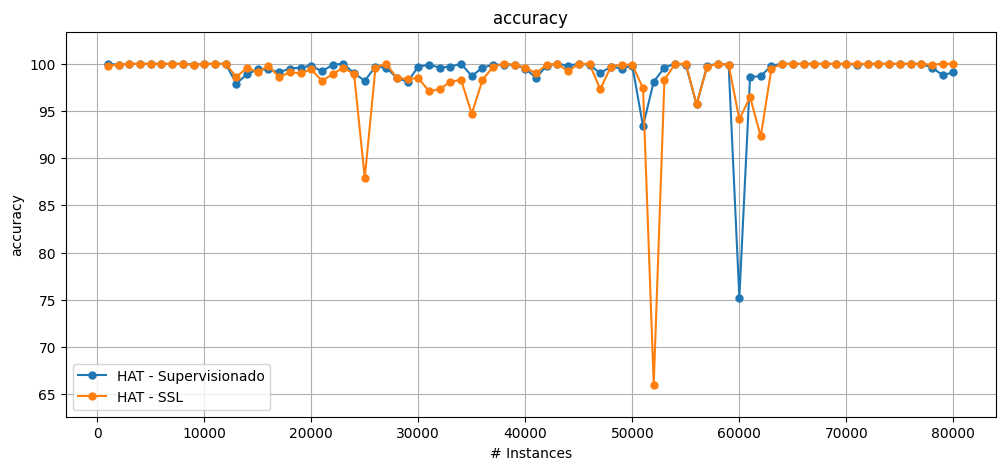

In [16]:
# Rótulos para os gráficos
result_prequential_HAT.learner = "HAT - Supervisionado"
result_ssl_prequential_HAT.learner = "HAT - SSL"

# Plot dos resultados
plot_windowed_results(
    result_prequential_HAT, 
    result_ssl_prequential_HAT,  
    metric="accuracy"
)

## Adaptive Random Forest (ARF)

https://capymoa.org/api/modules/capymoa.classifier.AdaptiveRandomForestClassifier.html#capymoa.classifier.AdaptiveRandomForestClassifier

* **schema** – O esquema do fluxo. Se não for fornecido, será inferido a partir dos dados.
* **CLI** – Opções da Interface de Linha de Comando (CLI) para configurar o algoritmo ARF. Se não forem fornecidas, as opções padrão serão utilizadas.
* **random_seed** – Semente para o gerador de números aleatórios.
* **base_learner** – O modelo base a ser usado. Se não for fornecido, uma árvore de Hoeffding padrão será utilizada.
* **ensemble_size** – O número de árvores no conjunto.
* **max_features** – O número máximo de características a serem consideradas ao dividir um nó. Se fornecido como um número de ponto flutuante entre 0,0 e 1,0, representa a porcentagem de características a serem consideradas. Se fornecido como um número inteiro, especifica o número exato de características a serem consideradas. Se fornecido como a string “sqrt”, indica a raiz quadrada do número total de características. Se não for fornecido, o valor padrão é 60%.
* **lambda_param** – O parâmetro lambda que controla a distribuição de Poisson para a simulação de bagging online.
* **minibatch_size** – O número de instâncias que um algoritmo de aprendizado deve acumular antes do treinamento.
* **number_of_jobs** – O número de tarefas paralelas a serem executadas durante a execução do algoritmo. Por padrão, o algoritmo executa as tarefas sequencialmente (ou seja, com `number_of_jobs=1` ). Aumentar o valor de `number_of_jobs` pode levar a uma execução mais rápida em sistemas com múltiplos núcleos. No entanto, definir um valor alto pode consumir mais recursos do sistema e memória. Esta implementação foi projetada para ser extremamente paralela, o que significa que os cálculos do algoritmo podem ser distribuídos eficientemente entre várias unidades de processamento sem sacrificar o desempenho preditivo. Recomenda-se experimentar com diferentes valores para encontrar a configuração ideal com base nos recursos de hardware disponíveis e na natureza da carga de trabalho.
* **drift_detection_method** – O método usado para detecção de deriva.
* **warning_detection_method** – O método usado para detecção de avisos.
* **disable_weighted_vote** – Indica se a votação ponderada deve ser desativada.
* **disable_drift_detection** – Indica se a detecção de deriva deve ser desativada.
* **disable_background_learner** – Indica se o aprendizado em segundo plano deve ser desativado.

### Hiperparâmetros

In [132]:
MAX_INSTANCES = 8000
WINDOW_SIZE = 100
DELAY_LENGTH = 300
LABEL_PROBABILITY = 0.1

ARF = AdaptiveRandomForestClassifier(
    schema=stream.schema,
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    max_features=0.6, # Padrão (0.6)
    lambda_param=6.0, # Padrão (6.0)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=1, # Padrão (1)
    drift_detection_method=None, # Padrão (None)
    warning_detection_method=None, # Padrão (None)
    disable_weighted_vote=False, # Padrão (False)
    disable_drift_detection=False, # Padrão (False)
    disable_background_learner=False # Padrão (False)        
)

classificationEvaluatorARF = ClassificationEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)
windowedEvaluatorARF = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)

drift_detector_DDM = DDM()
drift_detector_ADWIN = ADWIN()

# Para alterar entre as streams sintética e real
stream = streams["SEA_drift"]
print(stream.get_schema())

@relation 'generators.SEAGenerator '

@attribute attrib1 numeric
@attribute attrib2 numeric
@attribute attrib3 numeric
@attribute class {groupA,groupB}

@data


### ARF - Supervisionado

Resultados Cumulativos
Accuracy: 86.1875
F1_Score: 85.50905257958802


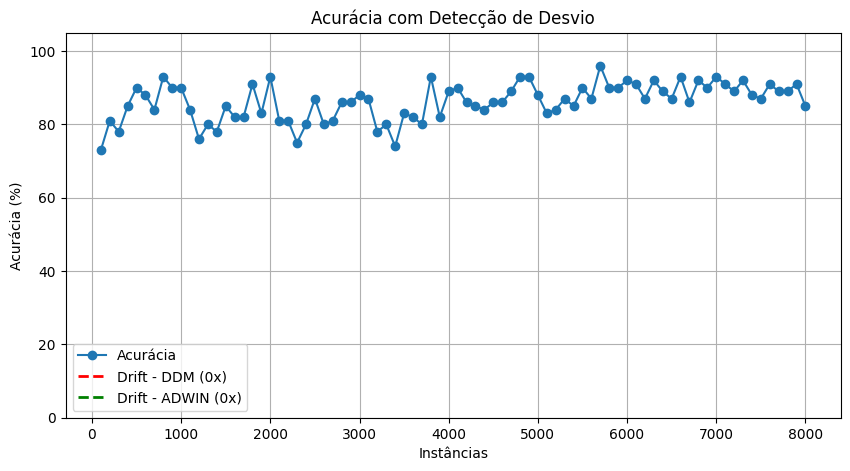

In [133]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    classificationEvaluatorARF.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    ARF.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorARF.accuracy()}")
print(f"F1_Score: {classificationEvaluatorARF.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(10, 5))
plt.plot(instance_count_history, window_accuracy_history, 'o-', label='Acurácia')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=2, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='--', 
           linewidth=2, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia com Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True)
plt.legend()
plt.show()

Supervisionado
Accuracy: 86.7875
f1_score: 86.18938048633761


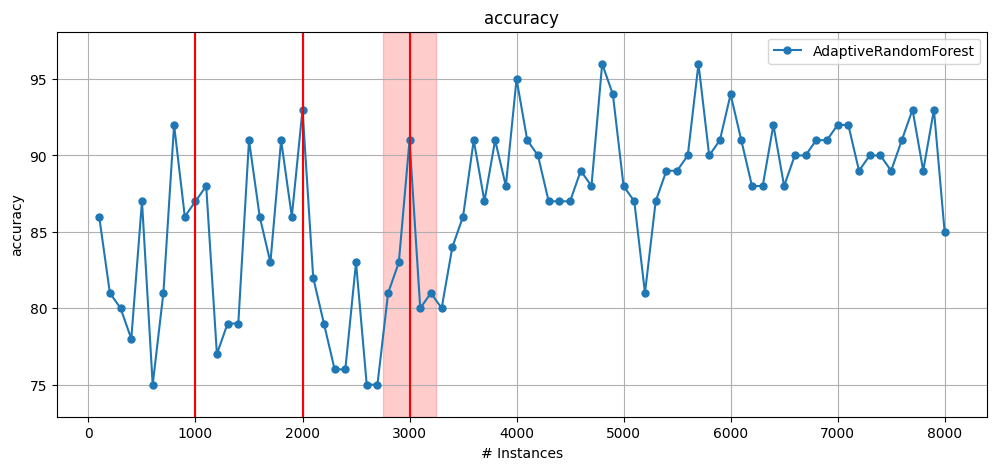

In [134]:
# Hyperparâmetros padrão
result_prequential_ARF = prequential_evaluation(
    stream=stream,
    learner=ARF,
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("Supervisionado")
print("Accuracy:", result_prequential_ARF['cumulative'].accuracy())
print("f1_score:", result_prequential_ARF['cumulative'].f1_score())
# display(result_prequential_ARF['windowed'].metrics_per_window())
plot_windowed_results(result_prequential_ARF, metric="accuracy")

### ARF - Semi-supervised Learning (SSL)

Resultados Cumulativos
Accuracy: 87.01875
F1_Score: 86.39849304753767


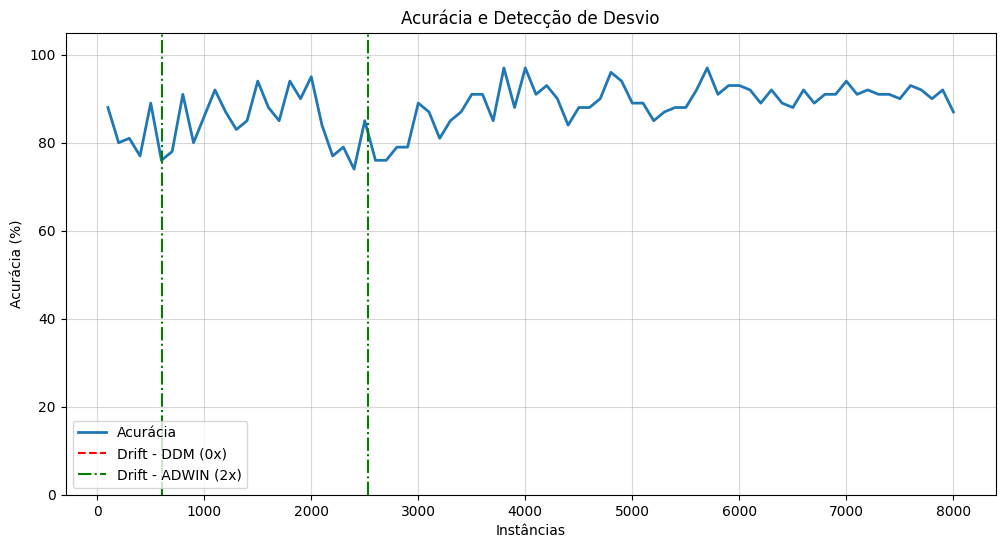

In [135]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Ocorre imediatamente
    prediction = ARF.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente
    classificationEvaluatorARF.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Se a instância for selecionada aleatoriamente (LABEL_PROBABILITY),
    # o modelo treina. Caso contrário, o treino é pulado.
    if random.random() <= LABEL_PROBABILITY:
        ARF.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1


print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorARF.accuracy()}")
print(f"F1_Score: {classificationEvaluatorARF.f1_score()}")

plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label=f'Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title(f'Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

SSL
Accuracy: 88.52499999999999
f1_score: 88.0581565530067


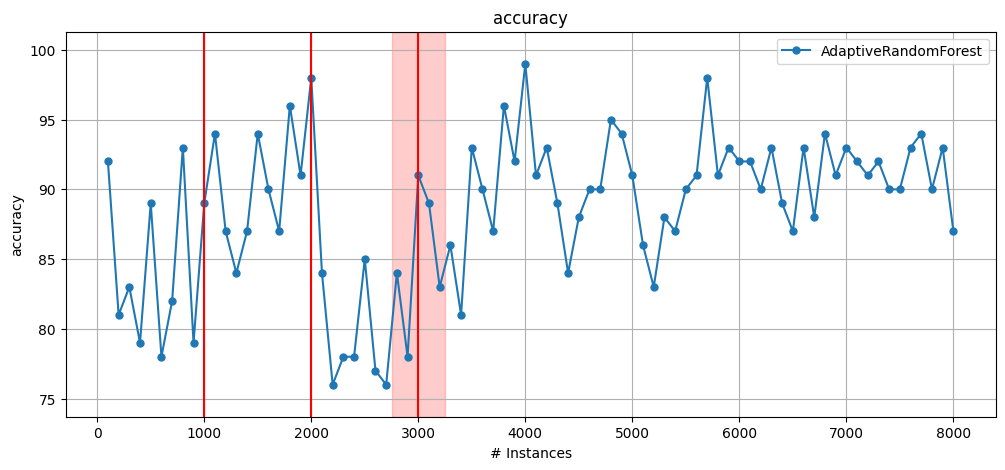

In [136]:
# Hyperparâmetros padrão para SSL
result_ssl_prequential_ARF = prequential_ssl_evaluation(
    stream=stream, 
    learner=ARF, 
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    initial_window_size=0,
    delay_length=0,
    label_probability=LABEL_PROBABILITY,
    random_seed=1,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("SSL")
print("Accuracy:", result_ssl_prequential_ARF['cumulative'].accuracy())
print("f1_score:", result_ssl_prequential_ARF['cumulative'].f1_score())
# display(result_ssl_prequential_ARF['windowed'].metrics_per_window())
plot_windowed_results(result_ssl_prequential_ARF, metric="accuracy")


### ARF - SSL com Delay

Resultados Cumulativos
Accuracy: 87.60416666666667
F1_Score: 87.03418470987071


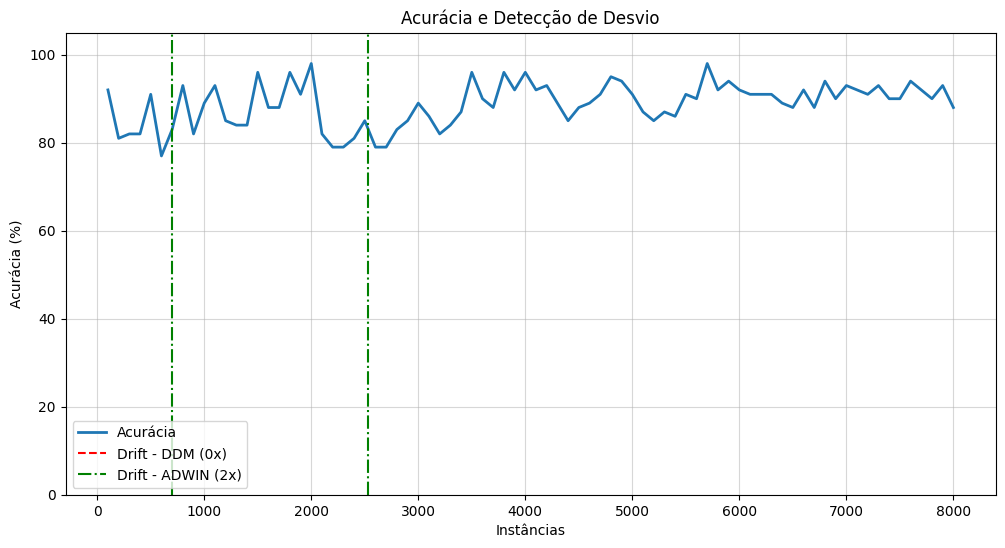

In [137]:
# Fila para armazenar instâncias para treino atrasado
prediction_queue = deque(maxlen=DELAY_LENGTH) 

window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE)  
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # (Predict) - Ocorre imediatamente
    prediction = ARF.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente com o rótulo conhecido
    classificationEvaluatorARF.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN 
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Determina se o rótulo está disponível (SSL)
    if random.random() <= LABEL_PROBABILITY:
        # Rótulo disponível: Armazenamos a instância completa para treino futuro
        prediction_queue.append(instance) 
    else:
        # Rótulo NÃO disponível: Armazenamos None para manter o delay
        prediction_queue.append(None)
        
    # TREINO ATRASADO (Delayed Train)
    if len(prediction_queue) == DELAY_LENGTH:
        delayed_item = prediction_queue.popleft()
        
        # Só treina se o rótulo estiver disponível no item que saiu da fila
        if delayed_item is not None:
            ARF.train(delayed_item)
            # print(f"Treinado na instância {count - DELAY_LENGTH + 1} com rótulo disponível.")
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorARF.accuracy()}")
print(f"F1_Score: {classificationEvaluatorARF.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label='Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

### Comparação dos resultados

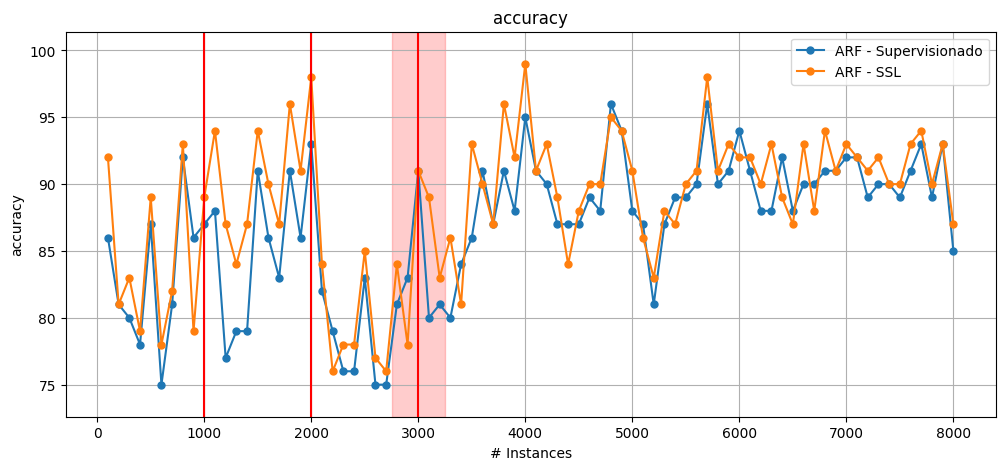

In [141]:
# Rótulos para os gráficos
result_prequential_ARF.learner = "ARF - Supervisionado"
result_ssl_prequential_ARF.learner = "ARF - SSL"

# Plot dos resultados
plot_windowed_results(
    result_prequential_ARF, 
    result_ssl_prequential_ARF, 
    metric="accuracy"
)